### Topic 1: Structural Properties of LADs
# Part 3: NL association of chromosome extremities

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
from scipy.signal import gaussian, fftconvolve
from matplotlib import gridspec
from scipy import signal
from scipy import stats

import sys
sys.path.append('../../combining_all_data/bin/')
sys.path.append('../bin/')
from preimplantation_toolkit import *
import preimplantation_load_data as ld

rs = np.random.RandomState()
rs.seed(42)

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
FIGOUTDIR = '../output/figures/1_Preimplantation.structural_properties_of_LADs.part3b.NL_association_of_chromosome_extremities.all_conditions/'

In [4]:
! mkdir -p $FIGOUTDIR || true;

In [5]:
HOME = '/Users/f.rang/surfdrive/Kind/data/'

BINSIZE = 100000
MINMAP_PER_KB = 1
MINMAP = int(MINMAP_PER_KB * BINSIZE / 1000)

ANNOFN = '../../combining_all_data/metadata/FR230814.samplesheet.tsv'
COLORFN = '../colors/manuscript_colors.tsv'

COUNTS = '../../combining_all_data/data/damid_counts/FR230814.DamID.sample_counts.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
BINARY = '../../combining_all_data/data/damid_binary/FR230814.DamID.sample_smooth_binary.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
CONTFC = '../../combining_all_data/data/damid_CF/FR230814.DamID.contact_frequency.{construct}.{stage}.{treatment}.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
INSILICO = '../../combining_all_data/data/damid_insilico/FR230814.DamID.insilico_counts.{construct}.{stage}.{treatment}.{genotype}.{sample}_samples.damid_pass.binsize_{binsize:d}.hdf5'

ALLELEFILTFN = '../../combining_all_data/data/damid_allelic_filter/FR230814.allelic_filter_based_on_visibility_and_bias.{genotype}.binsize_{binsize:d}.hdf5'

MAPFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.bowtie2_very_sensitive_N1.readlength_65.counts.pos.hdf5"
POSFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.posarray.hdf5"

# 1. Loading Kind data

In [6]:
color_dict = ld.load_color_dict(COLORFN)

## 1.1 Loading samplesheet

In [7]:
stage_order = ['zygote', '2cell', '8cell', 'mESC']
chrom_order = np.array([str(c) for c in range(1,20)] + ['X', 'Y'])

In [8]:
anno = pd.read_csv(ANNOFN, sep='\t', dtype={'number_embryos': str})

## select samples passing quality filters
anno = anno[anno.DamID_PASS]

## select conditions of interest
anno = anno[anno['construct'] == 'Lmnb1'].reset_index(drop=True)
anno = anno[anno['stage'].isin(stage_order)]
anno = anno[anno.cellcount == 1]
anno = anno[anno.treatment.isin(['no_treatment', 'EED_ctrl', 'EED_mKO', 'Cbx7(CD)-Lap2b', 'Lap2b'])]

# setting stage order
anno['stage'] = pd.Categorical(anno['stage'], categories=stage_order)
anno = anno.set_index(anno['damid_name'])

anno.head()

runid  illumina_index  damid2_adapter_number  \
damid_name                                                                      
KIN1971.index03.DamID2_BC_001  KIN1971               3                      1   
KIN1971.index03.DamID2_BC_009  KIN1971               3                      9   
KIN1971.index03.DamID2_BC_017  KIN1971               3                     17   
KIN1971.index03.DamID2_BC_025  KIN1971               3                     25   
KIN1971.index03.DamID2_BC_033  KIN1971               3                     33   

                               celseq2_adapter_number  cellcount construct  \
damid_name                                                                   
KIN1971.index03.DamID2_BC_001                       0          1     Lmnb1   
KIN1971.index03.DamID2_BC_009                       0          1     Lmnb1   
KIN1971.index03.DamID2_BC_017                       0          1     Lmnb1   
KIN1971.index03.DamID2_BC_025                       0          1     Lmnb1   
KIN1971.index03.DamID2_BC_033                       0          1     Lmnb1   

                              fusion_construct  stage     treatment  \
damid_name                                                            
KIN1971.index03.DamID2_BC_001        Dam-Lmnb1  2cell  no_treatment   
KIN1971.index03.DamID2_BC_009        Dam-Lmnb1  2cell  no_treatment   
KIN1971.index03.DamID2_BC_017        Dam-Lmnb1  2cell  no_treatment   
KIN1971.index03.DamID2_BC_025        Dam-Lmnb1  2cell  no_treatment   
KIN1971.index03.DamID2_BC_033        Dam-Lmnb1  2cell  no_treatment   

                                 genotype  ... nGenes nTranscripts  \
damid_name                                 ...                       
KIN1971.index03.DamID2_BC_001  homozygous  ...      0            0   
KIN1971.index03.DamID2_BC_009  homozygous  ...      0            0   
KIN1971.index03.DamID2_BC_017  homozygous  ...      0            0   
KIN1971.index03.DamID2_BC_025  homozygous  ...      0            0   
KIN1971.index03.DamID2_BC_033  homozygous  ...      0            0   

                              nTranscripts_maternal nTranscripts_paternal  \
damid_name                                                                  
KIN1971.index03.DamID2_BC_001                   NaN                   NaN   
KIN1971.index03.DamID2_BC_009                   NaN                   NaN   
KIN1971.index03.DamID2_BC_017                   NaN                   NaN   
KIN1971.index03.DamID2_BC_025                   NaN                   NaN   
KIN1971.index03.DamID2_BC_033                   NaN                   NaN   

                              allelic_celseq_balance nERCC nMito  DamID_PASS  \
damid_name                                                                     
KIN1971.index03.DamID2_BC_001                    NaN     0     0        True   
KIN1971.index03.DamID2_BC_009                    NaN     0     0        True   
KIN1971.index03.DamID2_BC_017                    NaN     0     0        True   
KIN1971.index03.DamID2_BC_025                    NaN     0     0        True   
KIN1971.index03.DamID2_BC_033                    NaN     0     0        True   

                              DamID_PASS_allelic CELseq_PASS  
damid_name                                                    
KIN1971.index03.DamID2_BC_001               True       False  
KIN1971.index03.DamID2_BC_009               True       False  
KIN1971.index03.DamID2_BC_017               True       False  
KIN1971.index03.DamID2_BC_025               True       False  
KIN1971.index03.DamID2_BC_033               True       False  

[5 rows x 38 columns]

## 1.2 Loading mappability

In [9]:
GENOTYPE2PARENT = {
    '129S1/SvImJ_x_CAST/EiJ': {
        'maternal': 'unique_129S1_SvImJ_snps',
        'paternal': 'unique_CAST_EiJ_snps'
    },
    
    'CBAB6F1_x_CAST/EiJ': {
        'maternal': 'unique_CBABL6F1_snps',
        'paternal': 'unique_CAST_snps'
    },
    
    'C57BL/6J_x_JF1/Ms': {
        'maternal': 'unique_C57BL_6J_snps',
        'paternal': 'unique_JF1_Ms_snps'
    }
}

In [10]:
mapab = ld.load_mappability(POSFN, MAPFN, chrom_order, BINSIZE)

In [11]:
mapab_gt = ld.load_mapab_from_count_file_heterozygous(COUNTS, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

## 1.3 Loading data

__DamID sample counts__

In [12]:
damid_counts = ld.load_sample_damid_counts_heterozygous(COUNTS, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ maternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ paternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ combined
Dam-Lmnb1 C57BL/6J_x_JF1/Ms maternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms paternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms combined
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ maternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ paternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ combined
Dam-Lmnb1 homozygous combined


__DamID binary__

In [13]:
damid_binary = ld.load_sample_damid_binary_heterozygous(BINARY, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ maternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ paternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ combined
Dam-Lmnb1 C57BL/6J_x_JF1/Ms maternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms paternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms combined
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ maternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ paternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ combined
Dam-Lmnb1 homozygous combined


__Contact Frequency__

In [14]:
contact_freq =  {p: dict() for p in ['maternal', 'paternal', 'combined']}

for info, df in anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment', 'is_heterozygous']):

    # load combined
    gt_name = info[2] if not info[-1] else info[2].replace('/','') + '.combined'
    fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)
    name = (info[1], info[2], info[3])

    if len(glob(fn)) == 0:
        print('CF does not exist for', info)
        continue

    contact_freq['combined'][name] =  load_count_file(fn)

    if info[-1]:
        for parent, gt in GENOTYPE2PARENT[info[2]].items():
            gt_name = info[2].replace('/','') + '.' + gt
            fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)
            contact_freq[parent][name] =  load_count_file(fn)

## 1.4 Loading allele visibility

In [15]:
allele_filt_gt = dict()

for gt in GENOTYPE2PARENT:
    
    fn = ALLELEFILTFN.format(genotype=gt.replace('/',''), binsize=BINSIZE)
    allele_filt_gt[gt] = dict()
    
    with h5py.File(fn, 'r') as f:
        for c in chrom_order:
            allele_filt_gt[gt][c] = f[c][:].astype(bool)
    
allele_filt_total = dict()

for c in chrom_order:
    filt = np.array([allele_filt_gt[gt][c] for gt in allele_filt_gt]).astype(int)
    filt = filt.sum(axis=0) == len(allele_filt_gt.keys())
    allele_filt_total[c] = filt

# 3. Comparing signal at left and right chromosome arms across stages

## 3.1 Contact Frequency of all stages for all chromosomes - whole chrom length

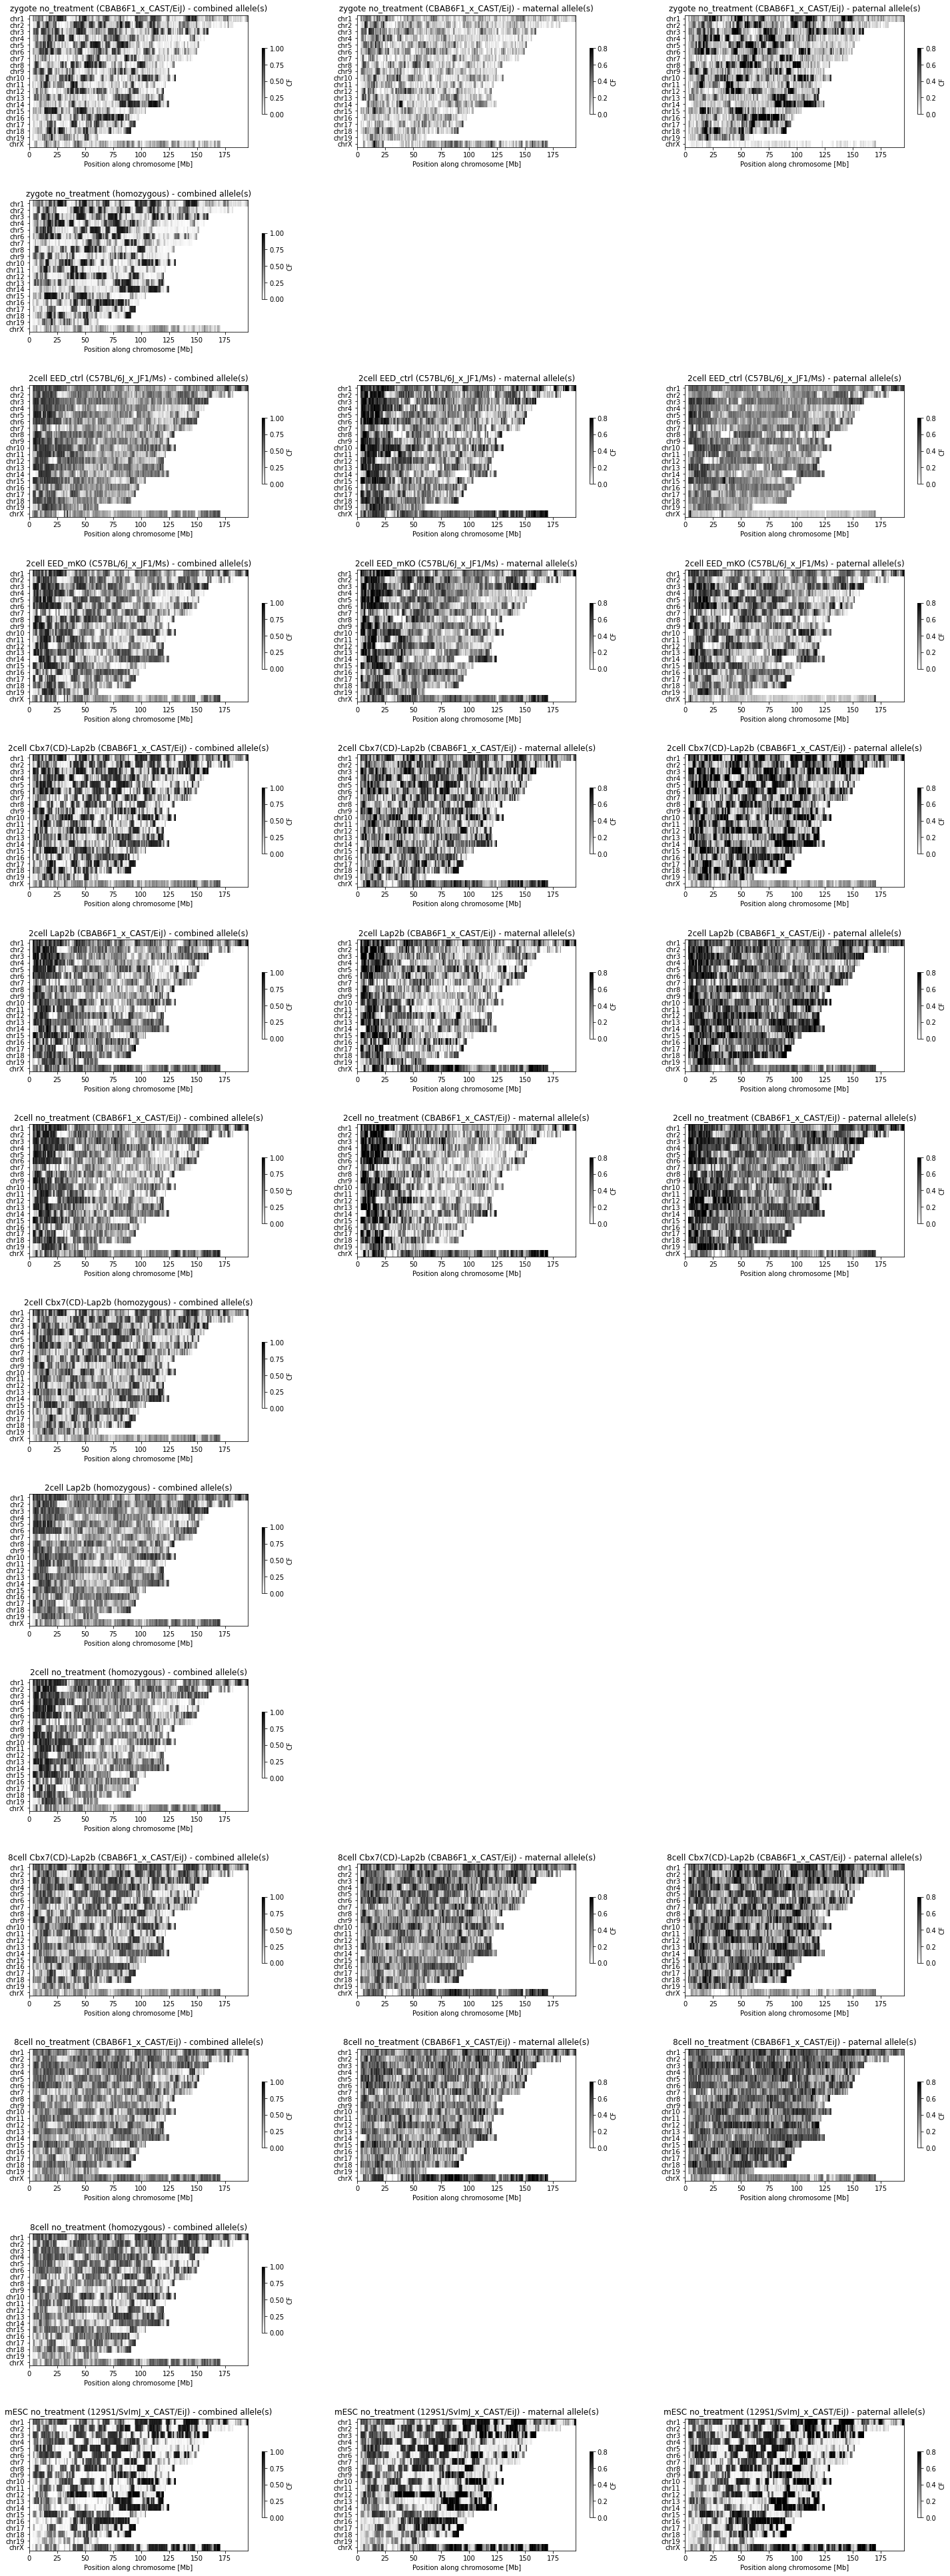

In [16]:
nrow = len(contact_freq['combined'].keys())
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(25, 5*nrow))
plt.subplots_adjust(hspace=.4)
r_counter = 0

for (stage, genotype, treatment, is_het), _ in anno.groupby(['stage', 'genotype', 'treatment', 'is_heterozygous']):
    
    for icol, parent in enumerate(['combined', 'maternal', 'paternal']):

        ax = axes[r_counter,icol]
        
        if (not is_het) and (parent != 'combined'):
            ax.remove()
            continue
        
        ax.set_title('%s %s (%s) - %s allele(s)' % (stage, treatment, genotype, parent))
        xmax = 0

        vmax = 1 if parent == 'combined' else 0.8
        for y, chrom in enumerate(chrom_order[:-1]):
            C = contact_freq[parent][(stage, genotype, treatment)][chrom]
            ext = [0, len(C)*BINSIZE/1e6, -y, -y-1]
            C = np.atleast_2d(C)
            p = ax.imshow(C, extent=ext, aspect='auto', cmap='binary', vmin=0, vmax=vmax)
            if chrom == '1':
                cbar = plt.colorbar(p, ax=ax, shrink=.5)
                cbar.ax.set_ylabel('CF')
            xmax = max(xmax, ext[1])

        ax.set_ylim(-y-1,0)
        ax.set_xlim(0,xmax)
        ax.set_yticks(np.arange(-y,1)-.5)
        ax.set_yticklabels(['chr' + c for c in chrom_order[:-1]][::-1])
        ax.set_xlabel('Position along chromosome [Mb]')
        
    r_counter += 1
    
outfn = FIGOUTDIR + 'CF_profile_heatmap_all_chromosomes.pdf'
plt.savefig(outfn, bbox_inches='tight')

## 3.2 Contact Frequency of all stages for all chromosomes - first 50Mb - sorted by CF of 2-cell

In [17]:
import matplotlib

In [18]:
cvals  = [0, .6, 1]
colors = ["white","lightgrey","black"]
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

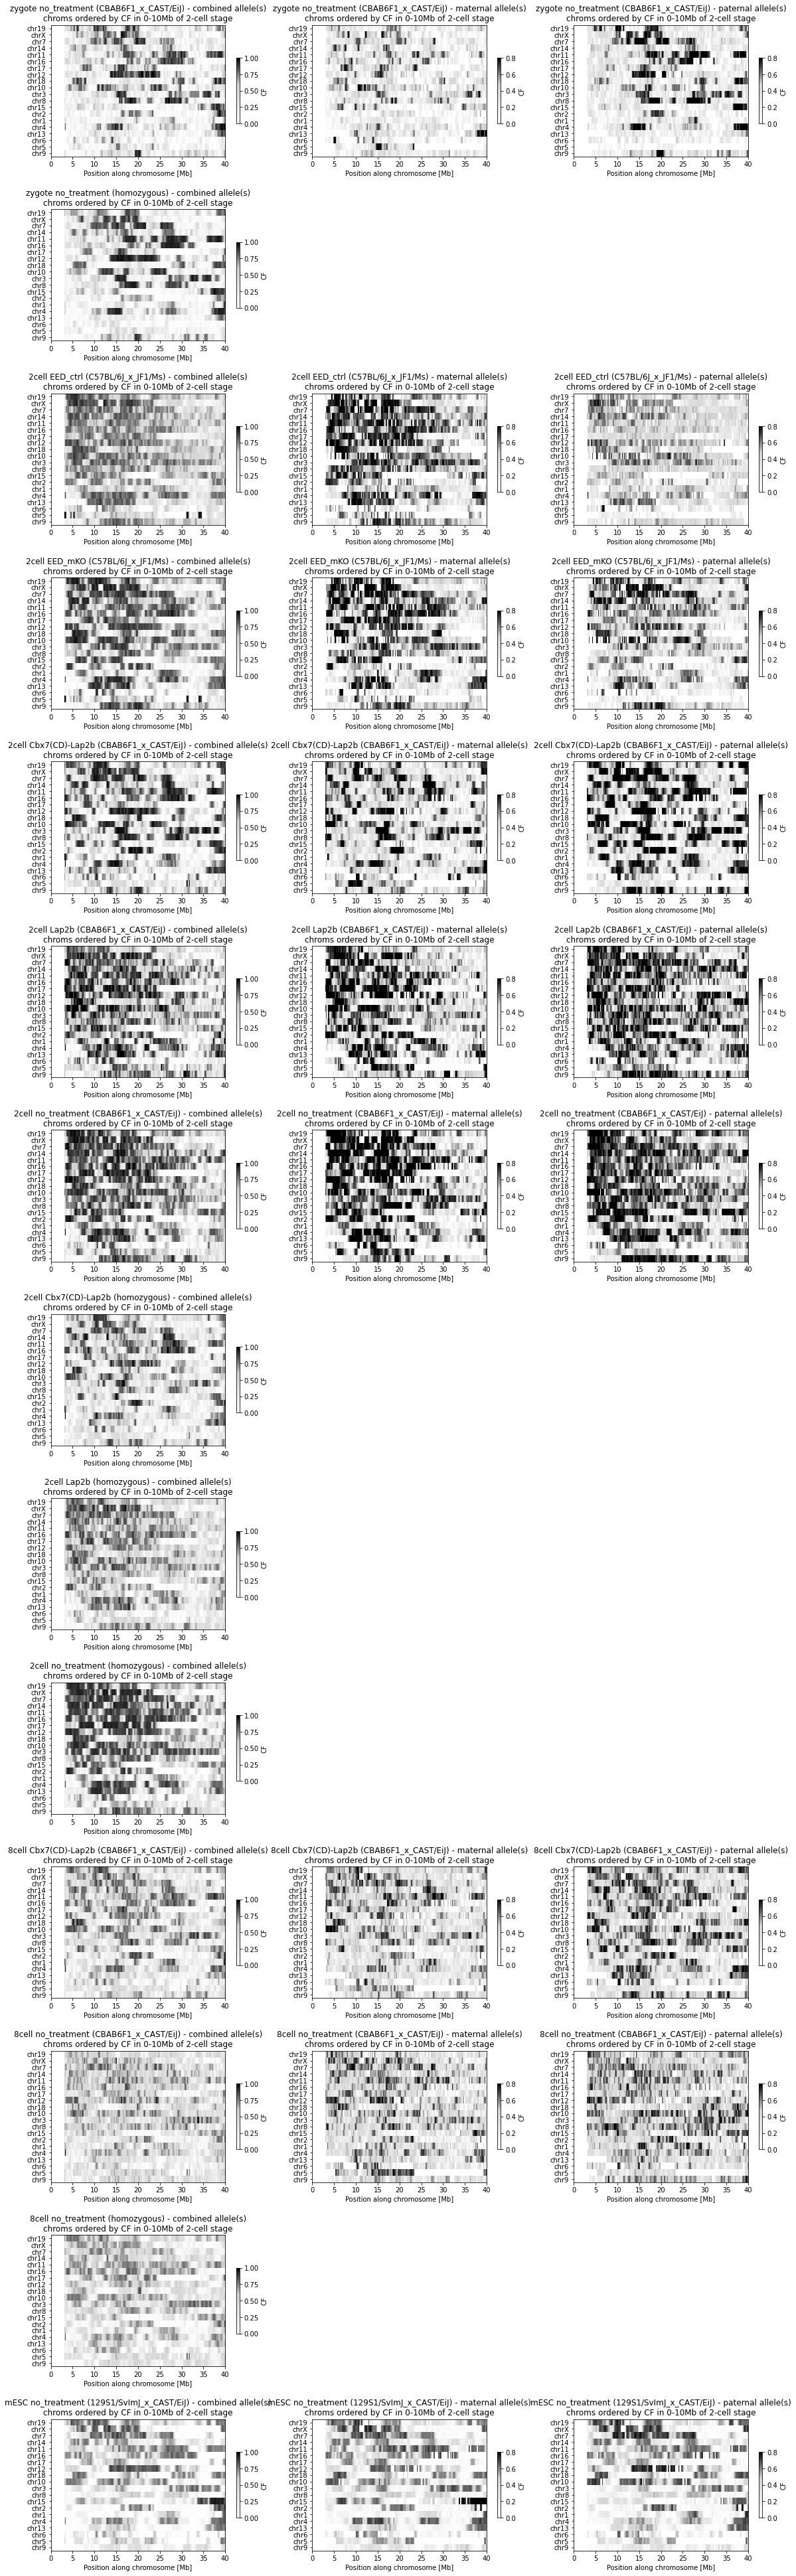

In [19]:
nrow = len(contact_freq['combined'].keys())
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 5*nrow))
plt.subplots_adjust(hspace=.4)
r_counter = 0
mb = 40

ref_sample = ('2cell', 'homozygous', 'no_treatment')
twocell_vals = np.array([contact_freq['combined'][ref_sample][c][:int(1e7/BINSIZE)].mean() for c in chrom_order[:-1]])
plot_order = np.argsort(twocell_vals)[::-1]

for (stage, genotype, treatment, is_het), _ in anno.groupby(['stage', 'genotype', 'treatment', 'is_heterozygous']):
    
    for icol, parent in enumerate(['combined', 'maternal', 'paternal']):

        ax = axes[r_counter,icol]
        
        if (not is_het) and (parent != 'combined'):
            ax.remove()
            continue
        
        ax.set_title('%s %s (%s) - %s allele(s)\nchroms ordered by CF in 0-10Mb of 2-cell stage' % (stage, treatment, genotype, parent))
        xmax = 0
        
        vmax = 1 if parent == 'combined' else 0.8

        for y, chrom in enumerate(chrom_order[plot_order]):
            C = contact_freq[parent][(stage, genotype, treatment)][chrom]
            
            if parent != 'combined':
                a_filt = allele_filt_gt[genotype][chrom]
                C[~a_filt] = -.5
            
            ext = [0, len(C)*BINSIZE/1e6, -y, -y-1]
            C = np.atleast_2d(C)
            p = ax.imshow(C, extent=ext, aspect='auto', cmap=new_cmap, vmin=0, vmax=vmax)

            if chrom == '1':
                cbar = plt.colorbar(p, ax=ax, shrink=.5)
                cbar.ax.set_ylabel('CF')
            xmax = max(xmax, ext[1])

        ax.set_ylim(-y-1,0)
        ax.set_xlim(0,mb)
        ax.set_yticks(np.arange(-y,1)-.5)
        ax.set_yticklabels(['chr' + c for c in chrom_order[plot_order]])
        ax.set_xlabel('Position along chromosome [Mb]')
        
    r_counter += 1
    
outfn = FIGOUTDIR + 'CF_profile_heatmap_all_chromosomes.left_%d_Mb.pdf' % mb
plt.savefig(outfn, bbox_inches='tight')

## 3.3 Left & right arms of all chromosomes separately

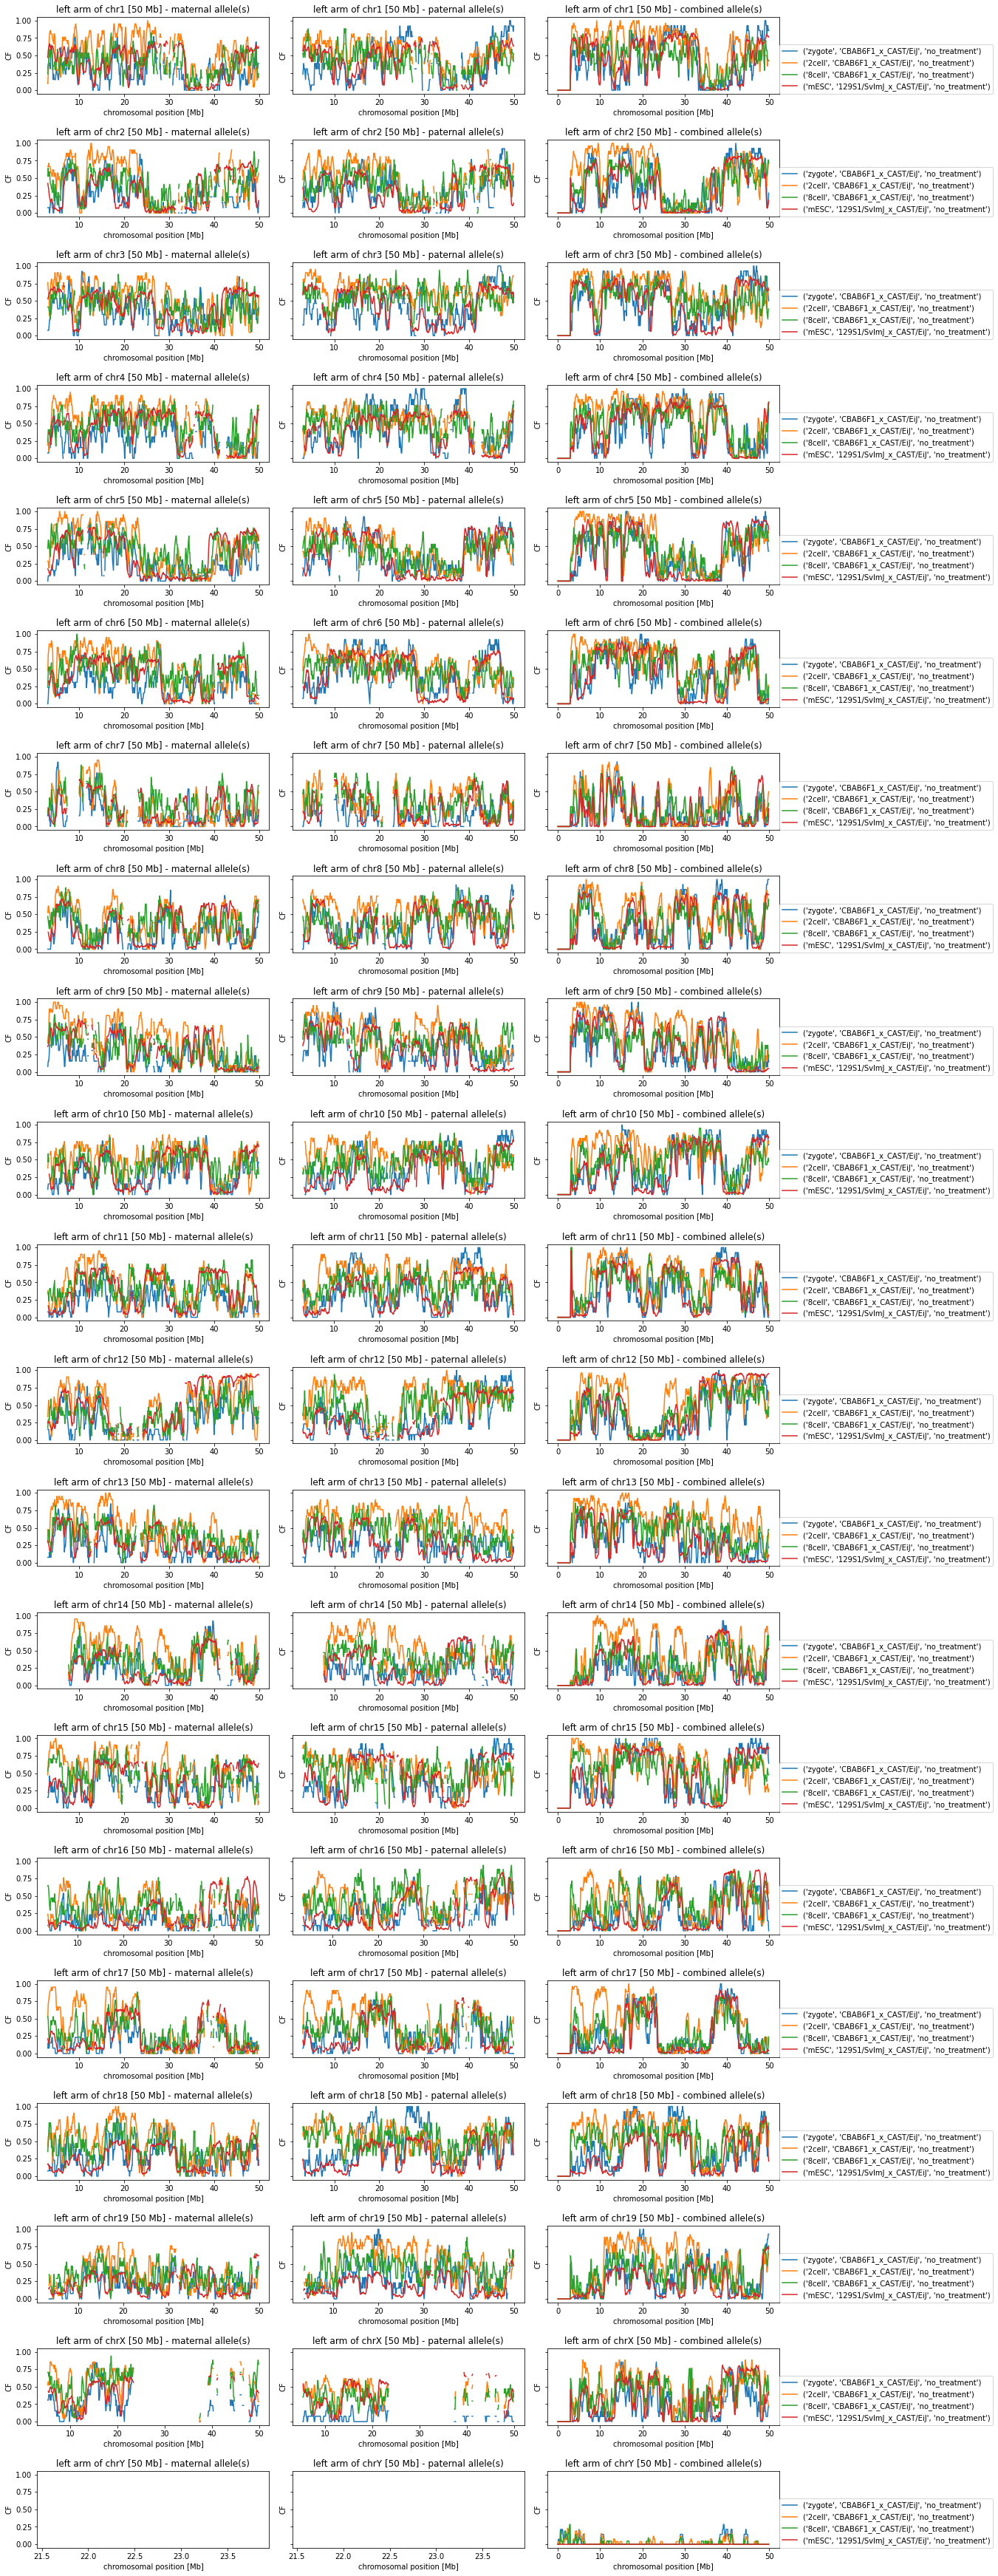

In [20]:
mb = 50
n_bins = int(mb*1e6 / BINSIZE)
arm = 'left'

nrow = len(chrom_order)
ncol = 3
fig, axes = plt.subplots(nrow,ncol,figsize=(18, 3*nrow), sharey=True)
plt.subplots_adjust(wspace=.1, hspace=.6)

ind_select = (anno.genotype != 'C57BL/6J_x_JF1/Ms') & (anno.treatment == 'no_treatment') & (anno.is_heterozygous)

clrtmp = {info: sns.color_palette('tab10',n_colors=10)[i] for i, (info, _) in enumerate(anno[ind_select].groupby(['stage', 'genotype', 'treatment']))}

for irow, chrom in enumerate(chrom_order):
    
    for icol, allele in enumerate(['maternal', 'paternal', 'combined']):
        ax = axes[irow,icol]
        ax.set_title('%s arm of chr%s [%d Mb] - %s allele(s)' % (arm, chrom, mb, allele))

        for (stage, genotype, treatment, is_het), _ in anno[ind_select].groupby(['stage', 'genotype', 'treatment', 'is_heterozygous']):
            
            if (not is_het) and (allele != 'combined'):
                continue
            
            Y = contact_freq[allele][(stage, genotype, treatment)][chrom][:n_bins]
            X = np.arange(0, n_bins*BINSIZE, BINSIZE) / 1e6
            if allele != 'combined':
                a_filt = allele_filt_gt[genotype][chrom][:n_bins]
                Y[~a_filt] = np.nan
            clr = clrtmp[(stage, genotype, treatment)]

            ax.plot(X, Y, label=(stage, genotype, treatment), c=clr)
            ax.set_xlabel('chromosomal position [Mb]')
            ax.set_ylabel('CF')

        if allele == 'combined':
            ax.legend(loc=(1,0))

# outfn = FIGOUTDIR + 'CF_of_left_and_right_arms.separate_chromosomes.pdf'
# plt.savefig(outfn, bbox_inches='tight')

## 3.4 Average CF at chromosome extremities per stage
Somatic chromosomes only

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_15540/1539639297.py:47: RuntimeWarning: Mean of empty slice
  Ym = np.nanmean(Y, axis=0)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_15540/1539639297.py:47: RuntimeWarning: Mean of empty slice
  Ym = np.nanmean(Y, axis=0)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_15540/1539639297.py:47: RuntimeWarning: Mean of empty slice
  Ym = np.nanmean(Y, axis=0)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_15540/1539639297.py:47: RuntimeWarning: Mean of empty slice
  Ym = np.nanmean(Y, axis=0)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_15540/1539639297.py:47: RuntimeWarning: Mean of empty slice
  Ym = np.nanmean(Y, axis=0)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_15540/1539639297.py:47: RuntimeWarning: Mean of empty slice
  Ym = np.nanmean(Y, axis=0)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_15540/1539639297.py:47: RuntimeWarning: Mean of empty

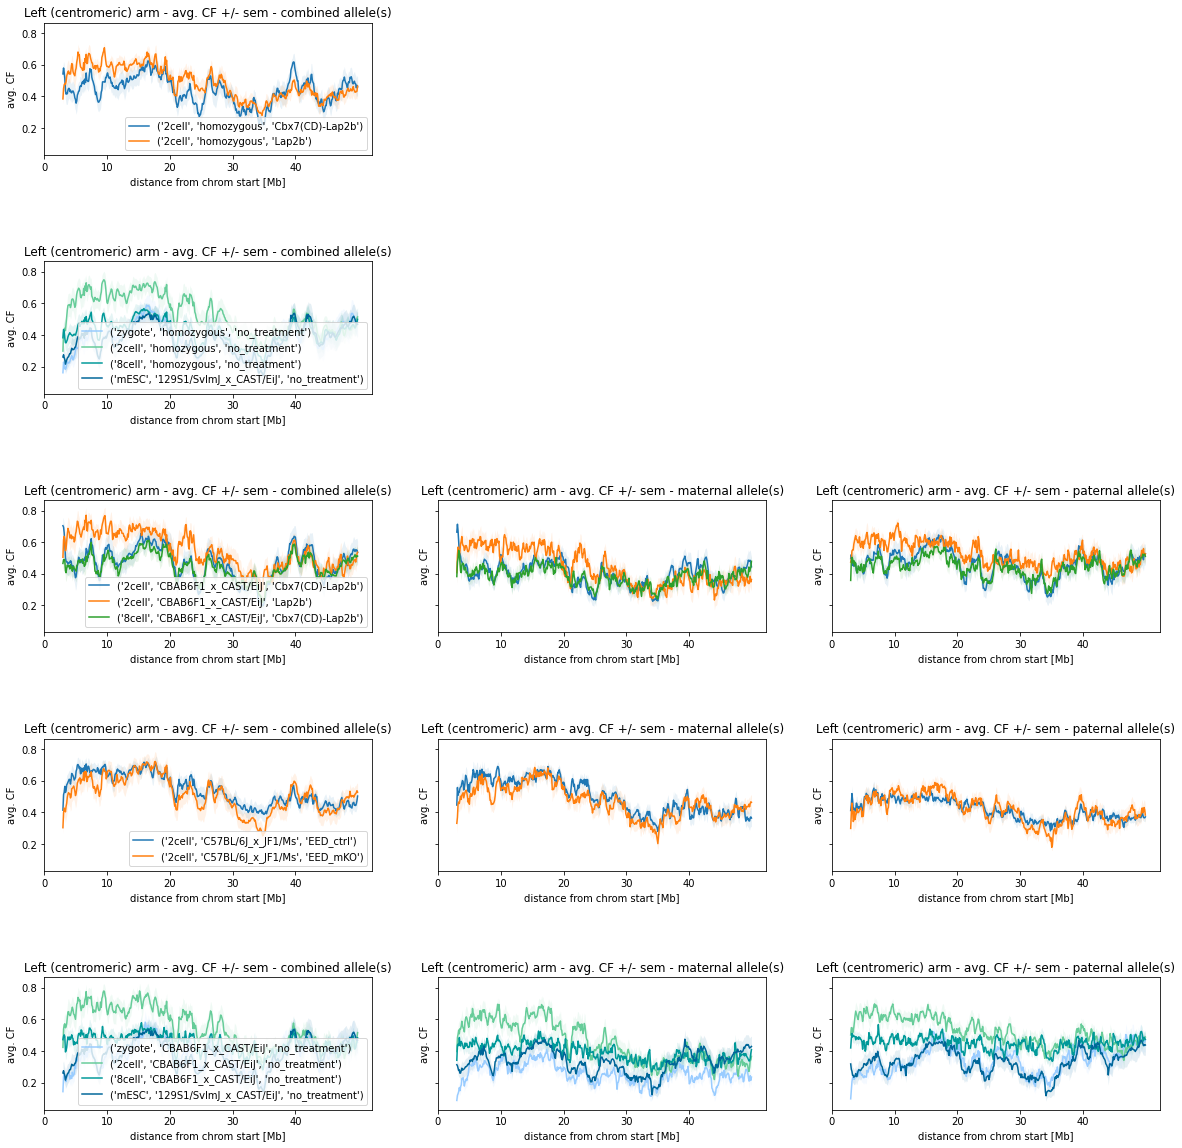

In [21]:
mb = 50
n_bins = int(mb*1e6 / BINSIZE)
arm = 'left'

to_plot = anno.copy()
to_plot['dataset'] = 'untreated'
to_plot.loc[to_plot.treatment.str.contains('EED'),'dataset'] = 'EED mKO'
to_plot.loc[to_plot.treatment.str.contains('Lap2b'),'dataset'] = 'Cbx7-Lap2b'
g_anno = to_plot.groupby(['is_heterozygous', 'dataset'])
nrow = len(list(g_anno))
ncol = 3

fig, axes = plt.subplots(nrow, ncol,figsize=(20,nrow*4), sharey=True)
plt.subplots_adjust(wspace=.2, hspace=.8)
r_counter = 0

for (is_het, dataset), subset_df in g_anno:
    
    if (not is_het) and (dataset == 'untreated'):
        ind = (to_plot.dataset == dataset) & (~to_plot.is_heterozygous)
        subset_df = to_plot[ind | (to_plot.stage == 'mESC')].copy()
    
    for icol, allele in enumerate(['combined', 'maternal', 'paternal']):
        ax = axes[r_counter, icol]
        
        if (not is_het) and (allele != 'combined'):
            ax.remove()
            continue

        iclr = 0
        # plot average CF per stage
        for condition, _ in subset_df.groupby(['stage', 'genotype', 'treatment']):
            
            Y = list()
            for chrom in chrom_order[:-2]:
                y = contact_freq[allele][condition][chrom]
                if allele != 'combined':
                    a_filt = allele_filt_gt[condition[1]][chrom]
                    y[~a_filt] = np.nan
                else:
                    m_filt = mapab[chrom] > MINMAP
                    y[~m_filt] = np.nan
                y = y[:n_bins] if arm == 'left' else y[-n_bins:]
                Y.append(y)

            Y = np.array(Y)
            Ym = np.nanmean(Y, axis=0)
            Ys = stats.sem(Y, axis=0, nan_policy='omit') #np.std(Y, axis=0)
            assert Y.shape[1] == n_bins

            X = np.arange(0, len(Ym))
            
            if dataset != 'untreated':
#                 clr = color_dict['treatment'][condition[2]]
                clr = sns.color_palette('tab10', n_colors=10)[iclr]
                iclr += 1
            else:
                clr = color_dict['stage'][condition[0]]
            ax.plot(X, Ym, label=condition, color=clr)
            ax.fill_between(X, Ym-Ys, Ym+Ys, color=clr, alpha=.1, lw=0)

        if allele == 'combined':
            ax.legend(loc='lower right')
        ax.grid(False)
        ax.set_ylabel('avg. CF')
        ax.set_xticks(np.arange(0, n_bins, int(10e6/BINSIZE)))

        if arm == 'left':
            ax.set_xticklabels(np.arange(0, mb, 10))
            ax.set_title('Left (centromeric) arm - avg. CF +/- sem - %s allele(s)' % allele)
            ax.set_xlabel('distance from chrom start [Mb]')
        else:
            ax.set_xticklabels(np.arange(mb, 0, -10))
            ax.set_title('Right arm - avg. CF +/- sem - %s allele(s)' % allele)
            ax.set_xlabel('distance from chrom end [Mb]')
            
    r_counter += 1
        
outfn = FIGOUTDIR + 'CF_of_%s_arm.avg_somatic_chromosomes.pdf' % arm
plt.savefig(outfn, bbox_inches='tight')

## 3.6 Average CF at over chromosome - smoothened & scaled
Somatic chromosomes only

In [22]:
import itertools

In [23]:
# determine unmappable region at the beginning of the chromosome
start_filt = dict()

for chrom in chrom_order:
    
    M = (mapab[chrom] > MINMAP).astype(int)
    tmp = itertools.groupby(M)
    first = next(tmp)
    assert first[0] == 0
    start_filt[chrom] = len(list(first[1]))

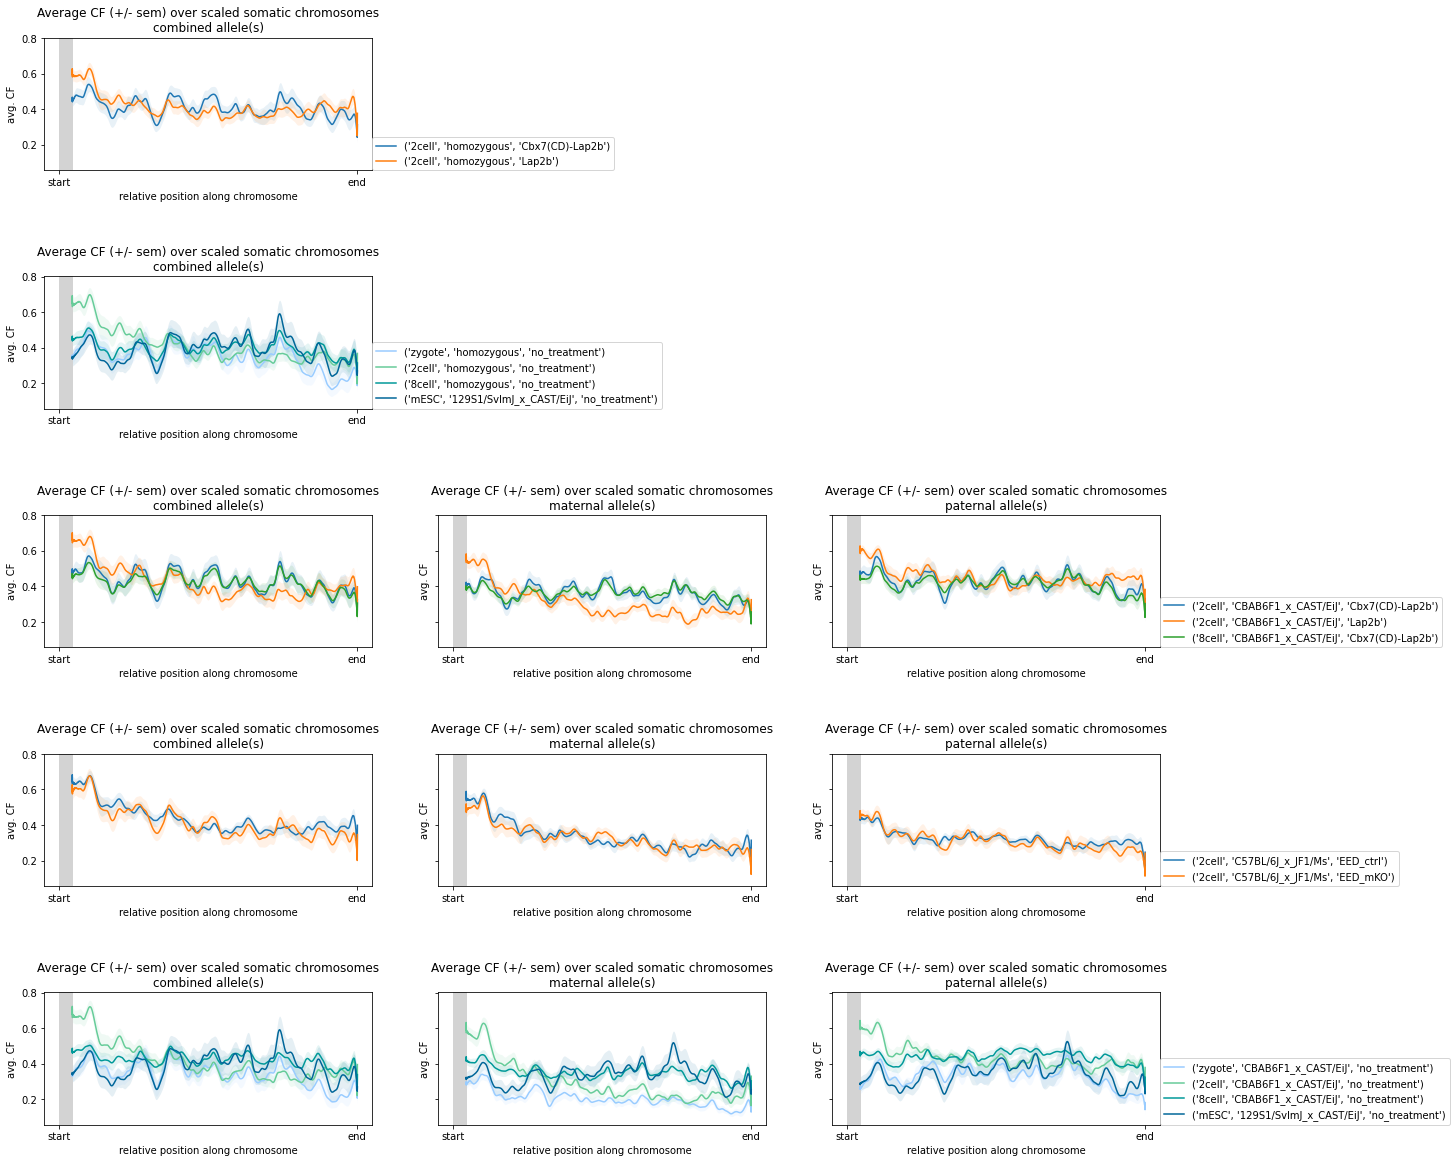

In [24]:
g_anno = to_plot.groupby(['is_heterozygous', 'dataset'])
nrow = len(list(g_anno))
ncol = 3

fig, axes = plt.subplots(nrow, ncol,figsize=(20,nrow*4), sharey=True)
plt.subplots_adjust(wspace=.2, hspace=.8)
r_counter = 0

nbins = max([len(mapab[c]) for c in chrom_order[:-2]])
smooth_std = 1000000
W = gaussian(np.ceil(smooth_std / BINSIZE * 6 / 2) * 2 + 1, smooth_std / BINSIZE)
W /= W.sum()

size_unmap = int(np.mean([start_filt[c] for c in chrom_order])) + len(W)

for (is_het, dataset), subset_df in g_anno:
    
    if (not is_het) and (dataset == 'untreated'):
        ind = (to_plot.dataset == dataset) & (~to_plot.is_heterozygous)
        subset_df = to_plot[ind | (to_plot.stage == 'mESC')].copy()
    
    for icol, allele in enumerate(['combined', 'maternal', 'paternal']):
        ax = axes[r_counter, icol]
        
        if (not is_het) and (allele != 'combined'):
            ax.remove()
            continue
            
        iclr = 0
        for condition, _ in subset_df.groupby(['stage', 'genotype', 'treatment']):
            Y = list()

            for chrom in chrom_order[:-2]:
                y = contact_freq[allele][condition][chrom]
                y[np.isnan(y)] = 0
                
                # smooth
                y = fftconvolve(y, W, mode='same')
                
                # exclude first unmappable region
                y = y[start_filt[chrom]+len(W):]
                
                # resize
                y = scipy.signal.resample(y, nbins)
                Y.append(y)

            Y = np.array(Y)
            Ym = np.nanmean(Y, axis=0)
            Ys = stats.sem(Y, axis=0, nan_policy='omit') #np.std(Y, axis=0)
            
            # add unmappable region at beginning
            unmap = np.zeros(size_unmap)
            unmap[:] = np.nan
            Ym = np.concatenate([unmap, Ym])
            Ys = np.concatenate([unmap, Ys])
            
            X = np.arange(0, len(Ym))
            
            if dataset != 'untreated':
                clr = sns.color_palette('tab10', n_colors=10)[iclr]
                iclr += 1
#                 clr = 'k' if condition[-1] == 'no_treatment' else 'r'
            else:
                clr = color_dict['stage'][condition[0]]
            
            ax.plot(X, Ym, label=condition, color=clr)
            ax.fill_between(X, Ym-Ys, Ym+Ys, color=clr, alpha=.1, lw=0)
            ax.axvspan(xmin=0, xmax=size_unmap, color='lightgrey')

        if (allele == 'combined') and not is_het:
            ax.legend(loc=(1,0))
        elif (allele == 'paternal'):
            ax.legend(loc=(1,0))
        ax.grid(False)
        ax.set_ylabel('avg. CF')
        ax.set_xlabel('relative position along chromosome')
        ax.set_xticks([0, X[-1]])
        ax.set_xticklabels(['start', 'end'])
        ax.set_title('Average CF (+/- sem) over scaled somatic chromosomes\n%s allele(s)' % allele)
    
    r_counter += 1

outfn = FIGOUTDIR + 'CF_of_left_and_right_arms.avg_somatic_chromosomes.chroms_%dkb-smoothened_scaled.pdf' % (smooth_std/1000)
plt.savefig(outfn, bbox_inches='tight')

## 3.7 Average CF at over chromosome - scaled & smoothened
Somatic chromosomes only

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_15540/1215122791.py:55: RuntimeWarning: Mean of empty slice
  Ym = np.nanmean(Y, axis=0)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_15540/1215122791.py:55: RuntimeWarning: Mean of empty slice
  Ym = np.nanmean(Y, axis=0)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_15540/1215122791.py:55: RuntimeWarning: Mean of empty slice
  Ym = np.nanmean(Y, axis=0)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_15540/1215122791.py:55: RuntimeWarning: Mean of empty slice
  Ym = np.nanmean(Y, axis=0)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_15540/1215122791.py:55: RuntimeWarning: Mean of empty slice
  Ym = np.nanmean(Y, axis=0)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_15540/1215122791.py:55: RuntimeWarning: Mean of empty slice
  Ym = np.nanmean(Y, axis=0)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_15540/1215122791.py:55: RuntimeWarning: Mean of empty

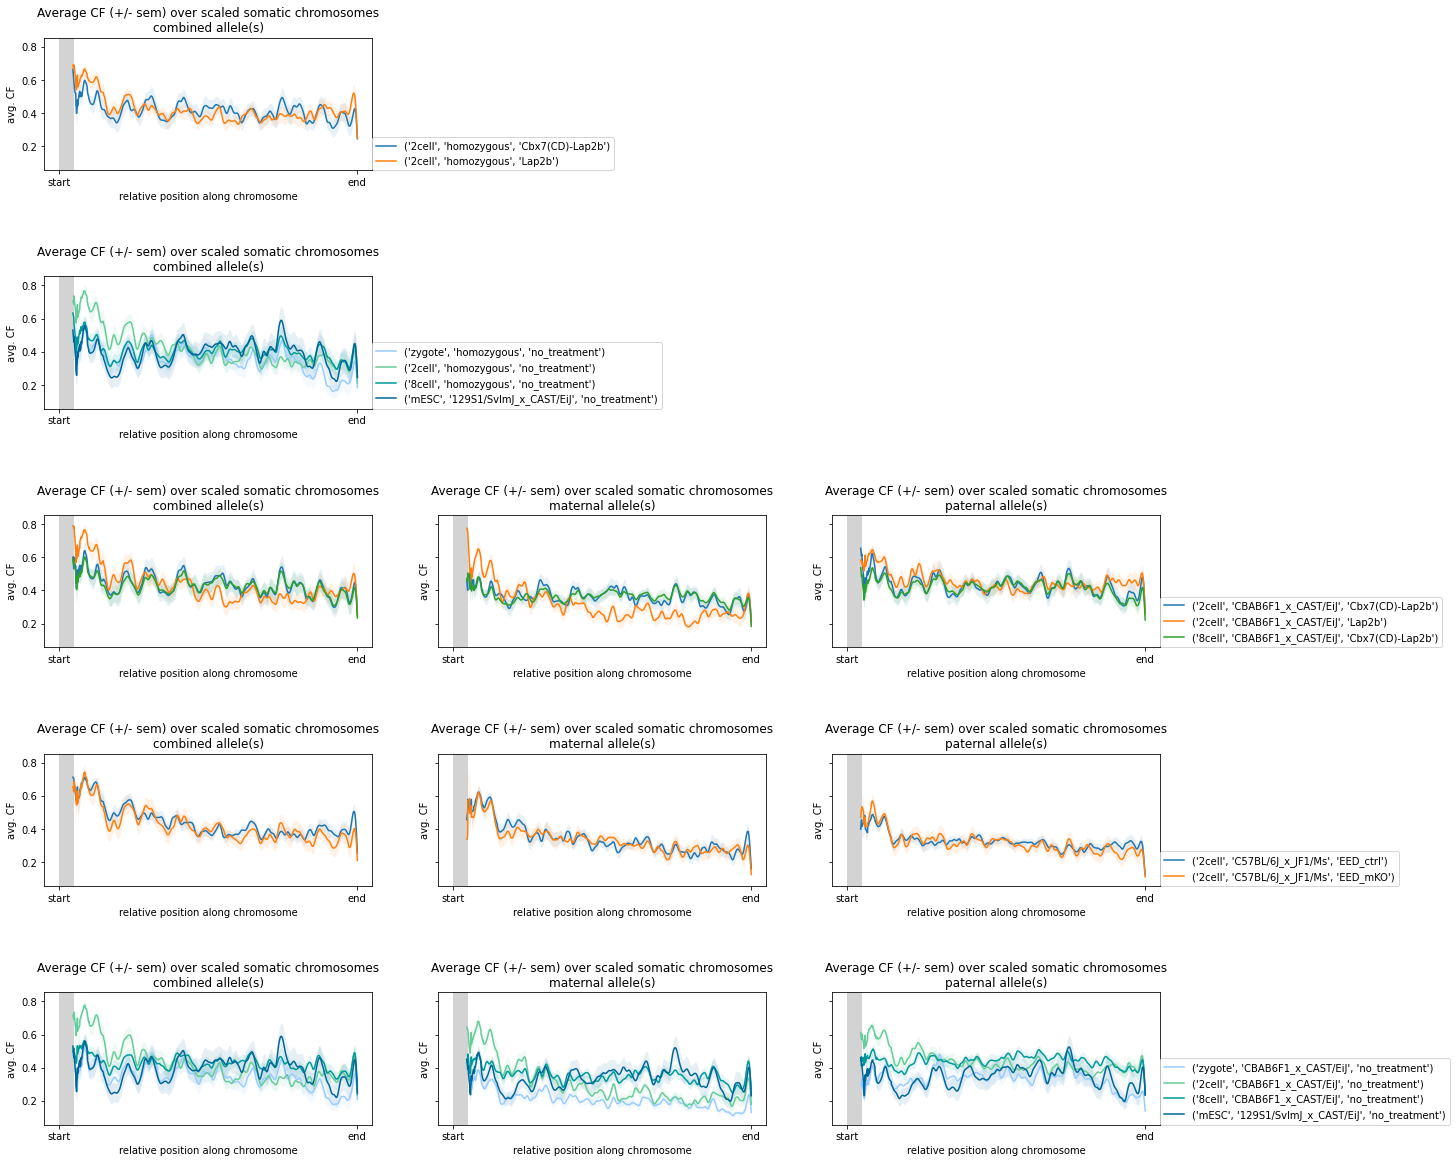

In [25]:
g_anno = to_plot.groupby(['is_heterozygous', 'dataset'])
nrow = len(list(g_anno))
ncol = 3

fig, axes = plt.subplots(nrow, ncol,figsize=(20,nrow*4), sharey=True)
plt.subplots_adjust(wspace=.2, hspace=.8)
r_counter = 0

nbins = max([len(mapab[c]) for c in chrom_order[:-2]])
smooth_std = 1000000
W = gaussian(np.ceil(smooth_std / BINSIZE * 6 / 2) * 2 + 1, smooth_std / BINSIZE)
W /= W.sum()

size_unmap = int(np.mean([start_filt[c] for c in chrom_order])) + len(W)

for (is_het, dataset), subset_df in g_anno:
    
    if (not is_het) and (dataset == 'untreated'):
        ind = (to_plot.dataset == dataset) & (~to_plot.is_heterozygous)
        subset_df = to_plot[ind | (to_plot.stage == 'mESC')].copy()
    
    for icol, allele in enumerate(['combined', 'maternal', 'paternal']):
        ax = axes[r_counter, icol]
        
        if (not is_het) and (allele != 'combined'):
            ax.remove()
            continue
            
        iclr = 0
        for condition, _ in subset_df.groupby(['stage', 'genotype', 'treatment']):
            Y = list()

            for chrom in chrom_order[:-2]:
                y = contact_freq[allele][condition][chrom]
                y[np.isnan(y)] = 0
                
                # resize
                y = scipy.signal.resample(y, nbins)
                
                # smooth
                y = fftconvolve(y, W, mode='same')
                
                # determine unmappable region in resamples array
                excl_ind = np.zeros_like(mapab[chrom])
                excl_ind[:start_filt[chrom]+len(W)] = 1
                excl_ind = scipy.signal.resample(excl_ind, nbins)
                excl_ind = (excl_ind > 0.5).astype(int)

                # set unmappable regions to nan
                y[excl_ind==1] = np.nan

                Y.append(y)

            Y = np.array(Y)
            Ym = np.nanmean(Y, axis=0)
            Ys = stats.sem(Y, axis=0, nan_policy='omit') #np.std(Y, axis=0)
            
            X = np.arange(0, len(Ym))
            
            if dataset != 'untreated':
                clr = sns.color_palette('tab10', n_colors=10)[iclr]
                iclr += 1
#                 clr = 'k' if condition[-1] == 'no_treatment' else 'r'
            else:
                clr = color_dict['stage'][condition[0]]
            
            ax.plot(X, Ym, label=condition, color=clr)
            ax.fill_between(X, Ym-Ys, Ym+Ys, color=clr, alpha=.1, lw=0)
            ax.axvspan(xmin=0, xmax=size_unmap, color='lightgrey')

        if (allele == 'combined') and not is_het:
            ax.legend(loc=(1,0))
        elif (allele == 'paternal'):
            ax.legend(loc=(1,0))
        ax.grid(False)
        ax.set_ylabel('avg. CF')
        ax.set_xlabel('relative position along chromosome')
        ax.set_xticks([0, X[-1]])
        ax.set_xticklabels(['start', 'end'])
        ax.set_title('Average CF (+/- sem) over scaled somatic chromosomes\n%s allele(s)' % allele)
    
    r_counter += 1

# outfn = FIGOUTDIR + 'CF_of_left_and_right_arms.avg_somatic_chromosomes.chroms_%dkb-scaled_smoothened.pdf' % (smooth_std/1000)
# plt.savefig(outfn, bbox_inches='tight')

## 3.7 Contact Frequency distribution at left arm vs rest - left = first 30Mb

In [16]:
from collections import defaultdict

In [17]:
MB_LEFT_ARM = 30
n_bins = int(MB_LEFT_ARM*1e6/BINSIZE)

to_plot = defaultdict(list)

for (stage, genotype, treatment, is_het), _ in anno.groupby(['stage', 'genotype', 'treatment', 'is_heterozygous']):
    
    alleles = ['combined', 'maternal', 'paternal'] if is_het else ['combined']
    
    for allele in alleles:
    
        for chrom in chrom_order[:-2]:

            m_ind = mapab[chrom] > MINMAP
            if allele == 'combined':
                filt = m_ind
            else:
                a_ind = allele_filt_gt[genotype][chrom]
                filt = a_ind & m_ind
                
            cf = contact_freq[allele][(stage, genotype, treatment)][chrom]
            n = len(cf)

            to_plot['stage'].append( np.repeat(stage, n) )
            to_plot['genotype'].append( np.repeat(genotype, n) )
            to_plot['treatment'].append( np.repeat(treatment, n) )
            to_plot['is_het'].append( np.repeat(is_het, n) )
            to_plot['chrom'].append( np.repeat(chrom, n) )
            to_plot['allele'].append( np.repeat(allele, n) )
            to_plot['CF'].append(cf)
            to_plot['filt'].append(filt)

            region = np.concatenate( [np.repeat('left_%dMb' % MB_LEFT_ARM, n_bins), np.repeat('rest', n-n_bins)] )
            to_plot['region'].append(region)

for k in to_plot:
    to_plot[k] = np.concatenate(to_plot[k])

to_plot = pd.DataFrame(to_plot)
to_plot = to_plot[to_plot.filt]
to_plot['label'] = to_plot.apply(axis=1, func = lambda r: '%s\n%s\n%s' % (r['stage'], r['genotype'], r['treatment']))

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_59730/136372902.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_59730/136372902.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_59730/136372902.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


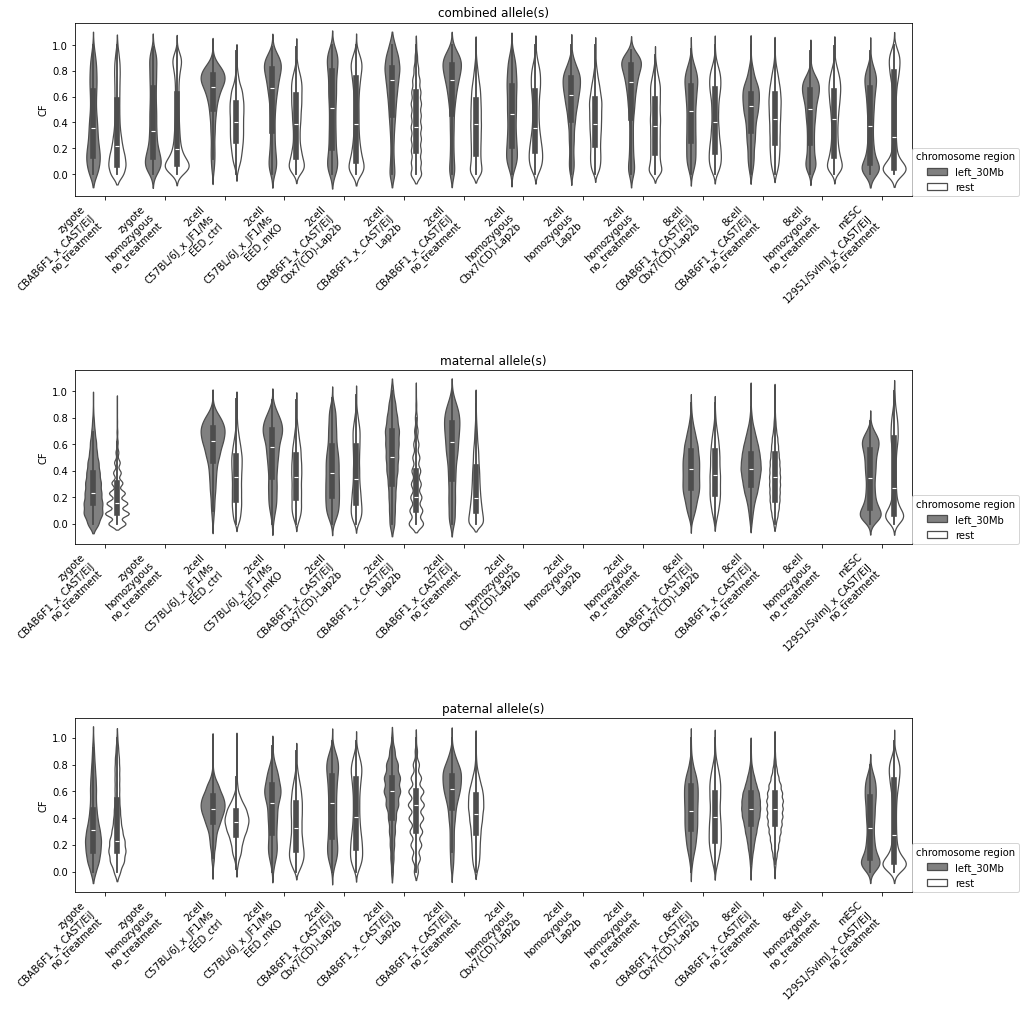

In [18]:
sample_order = to_plot['label'].unique()

fig, axes = plt.subplots(3, 1, figsize=(15,16))
plt.subplots_adjust(hspace=1)

clrs = {
    'left_%dMb' % MB_LEFT_ARM: 'grey',
    'rest': 'white'
}

for irow, allele in enumerate(['combined', 'maternal', 'paternal']):

    ind = to_plot.allele==allele
    ax = axes[irow]
    ax.set_title('%s allele(s)' % allele)

    sns.violinplot(
        x=to_plot.loc[ind,'label'], 
        y=to_plot.loc[ind, 'CF'], 
        hue=to_plot.loc[ind, 'region'], 
        palette=clrs,
        order=sample_order,
        ax = ax
    )
    ax.legend(loc=(1,0), title='chromosome region')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')

outfn = FIGOUTDIR + 'CF_distribution_of_left_arm_vs_rest.left_%dMb.pdf' % MB_LEFT_ARM
plt.savefig(outfn, bbox_inches='tight')

In [21]:
stat_test_results = defaultdict(list)

for (stage, genotype, treatment, allele), df in to_plot.groupby(['stage', 'genotype', 'treatment', 'allele']):
    
    A = df.loc[df.region == 'left_30Mb', 'CF'].values
    B = df.loc[df.region == 'rest', 'CF'].values
    results = stats.mannwhitneyu(A, B, alternative='two-sided')
    
    stat_test_results['stage'].append(stage)
    stat_test_results['genotype'].append(genotype)
    stat_test_results['treatment'].append(treatment)
    stat_test_results['allele'].append(allele)
    stat_test_results['region_1'].append('left_30Mb')
    stat_test_results['region_2'].append('rest')
    stat_test_results['N_1'].append(len(A))
    stat_test_results['N_2'].append(len(B))
    stat_test_results['mean_1'].append(np.mean(A))
    stat_test_results['mean_2'].append(np.mean(B))
    stat_test_results['median_1'].append(np.median(A))
    stat_test_results['median_2'].append(np.median(B))
    stat_test_results['std_1'].append(np.std(A))
    stat_test_results['std_2'].append(np.std(B))
    stat_test_results['MWU_stat'].append(results[0])
    stat_test_results['MWU_pval'].append(results[1])
    
pd.DataFrame(stat_test_results)

stage                genotype       treatment    allele   region_1  \
0    2cell       C57BL/6J_x_JF1/Ms        EED_ctrl  combined  left_30Mb   
1    2cell       C57BL/6J_x_JF1/Ms        EED_ctrl  maternal  left_30Mb   
2    2cell       C57BL/6J_x_JF1/Ms        EED_ctrl  paternal  left_30Mb   
3    2cell       C57BL/6J_x_JF1/Ms         EED_mKO  combined  left_30Mb   
4    2cell       C57BL/6J_x_JF1/Ms         EED_mKO  maternal  left_30Mb   
5    2cell       C57BL/6J_x_JF1/Ms         EED_mKO  paternal  left_30Mb   
6    2cell      CBAB6F1_x_CAST/EiJ  Cbx7(CD)-Lap2b  combined  left_30Mb   
7    2cell      CBAB6F1_x_CAST/EiJ  Cbx7(CD)-Lap2b  maternal  left_30Mb   
8    2cell      CBAB6F1_x_CAST/EiJ  Cbx7(CD)-Lap2b  paternal  left_30Mb   
9    2cell      CBAB6F1_x_CAST/EiJ           Lap2b  combined  left_30Mb   
10   2cell      CBAB6F1_x_CAST/EiJ           Lap2b  maternal  left_30Mb   
11   2cell      CBAB6F1_x_CAST/EiJ           Lap2b  paternal  left_30Mb   
12   2cell      CBAB6F1_x_CAST/EiJ    no_treatment  combined  left_30Mb   
13   2cell      CBAB6F1_x_CAST/EiJ    no_treatment  maternal  left_30Mb   
14   2cell      CBAB6F1_x_CAST/EiJ    no_treatment  paternal  left_30Mb   
15   2cell              homozygous  Cbx7(CD)-Lap2b  combined  left_30Mb   
16   2cell              homozygous           Lap2b  combined  left_30Mb   
17   2cell              homozygous    no_treatment  combined  left_30Mb   
18   8cell      CBAB6F1_x_CAST/EiJ  Cbx7(CD)-Lap2b  combined  left_30Mb   
19   8cell      CBAB6F1_x_CAST/EiJ  Cbx7(CD)-Lap2b  maternal  left_30Mb   
20   8cell      CBAB6F1_x_CAST/EiJ  Cbx7(CD)-Lap2b  paternal  left_30Mb   
21   8cell      CBAB6F1_x_CAST/EiJ    no_treatment  combined  left_30Mb   
22   8cell      CBAB6F1_x_CAST/EiJ    no_treatment  maternal  left_30Mb   
23   8cell      CBAB6F1_x_CAST/EiJ    no_treatment  paternal  left_30Mb   
24   8cell              homozygous    no_treatment  combined  left_30Mb   
25    mESC  129S1/SvImJ_x_CAST/EiJ    no_treatment  combined  left_30Mb   
26    mESC  129S1/SvImJ_x_CAST/EiJ    no_treatment  maternal  left_30Mb   
27    mESC  129S1/SvImJ_x_CAST/EiJ    no_treatment  paternal  left_30Mb   
28  zygote      CBAB6F1_x_CAST/EiJ    no_treatment  combined  left_30Mb   
29  zygote      CBAB6F1_x_CAST/EiJ    no_treatment  maternal  left_30Mb   
30  zygote      CBAB6F1_x_CAST/EiJ    no_treatment  paternal  left_30Mb   
31  zygote              homozygous    no_treatment  combined  left_30Mb   

   region_2   N_1    N_2    mean_1    mean_2  median_1  median_2     std_1  \
0      rest  4984  18767  0.610810  0.405342  0.678161  0.402299  0.213882   
1      rest  4388  16327  0.578847  0.350717  0.627451  0.352941  0.192801   
2      rest  4388  16327  0.457294  0.355061  0.470588  0.372549  0.143981   
3      rest  4984  18767  0.574683  0.384649  0.666667  0.388889  0.291606   
4      rest  4388  16327  0.533508  0.351806  0.580645  0.354839  0.228389   
5      rest  4388  16327  0.471741  0.340325  0.516129  0.322581  0.215311   
6      rest  4984  18767  0.495807  0.427462  0.512821  0.384615  0.310138   
7      rest  4865  18330  0.410683  0.370852  0.384615  0.333333  0.237963   
8      rest  4865  18330  0.489636  0.431428  0.512821  0.410256  0.261361   
9      rest  4984  18767  0.618452  0.388443  0.727273  0.363636  0.284501   
10     rest  4865  18330  0.517472  0.282171  0.500000  0.200000  0.260324   
11     rest  4865  18330  0.567091  0.441249  0.600000  0.500000  0.221923   
12     rest  4984  18767  0.632717  0.371472  0.730769  0.384615  0.281017   
13     rest  4865  18330  0.547076  0.258813  0.619048  0.190476  0.264313   
14     rest  4865  18330  0.579465  0.420432  0.619048  0.428571  0.212545   
15     rest  4984  18767  0.468177  0.408407  0.464286  0.357143  0.264427   
16     rest  4984  18767  0.555338  0.395540  0.612903  0.387097  0.232625   
17     rest  4984  18767  0.613280  0.377190  0.715736  0.375635  0.285186   
18     rest  4984  18767  0.470328  0.425029  0

## 3.8 Contact Frequency distribution at left arm vs rest - left = first 20% 

In [30]:
PCT_LEFT_ARM = 20
to_plot = defaultdict(list)

for (stage, genotype, treatment, is_het), _ in anno.groupby(['stage', 'genotype', 'treatment', 'is_heterozygous']):
    
    alleles = ['combined', 'maternal', 'paternal'] if is_het else ['combined']
    
    for allele in alleles:
    
        for chrom in chrom_order[:-2]:

            m_ind = mapab[chrom] > MINMAP
            if allele == 'combined':
                filt = m_ind
            else:
                a_ind = allele_filt_gt[genotype][chrom]
                filt = a_ind & m_ind
                
            cf = contact_freq[allele][(stage, genotype, treatment)][chrom]
            n = len(cf)

            to_plot['stage'].append( np.repeat(stage, n) )
            to_plot['genotype'].append( np.repeat(genotype, n) )
            to_plot['treatment'].append( np.repeat(treatment, n) )
            to_plot['is_het'].append( np.repeat(is_het, n) )
            to_plot['chrom'].append( np.repeat(chrom, n) )
            to_plot['allele'].append( np.repeat(allele, n) )
            to_plot['CF'].append(cf)
            to_plot['filt'].append(filt)

            n_pct = int(n*PCT_LEFT_ARM/100)
            region = np.concatenate( [np.repeat('left_%dpct' % PCT_LEFT_ARM, n_pct), np.repeat('rest', n-n_pct)] )
            to_plot['region'].append(region)

for k in to_plot:
    to_plot[k] = np.concatenate(to_plot[k])

to_plot = pd.DataFrame(to_plot)
to_plot = to_plot[to_plot.filt]
to_plot['label'] = to_plot.apply(axis=1, func = lambda r: '%s\n%s\n%s' % (r['stage'], r['genotype'], r['treatment']))

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_15540/3506799647.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_15540/3506799647.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_15540/3506799647.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


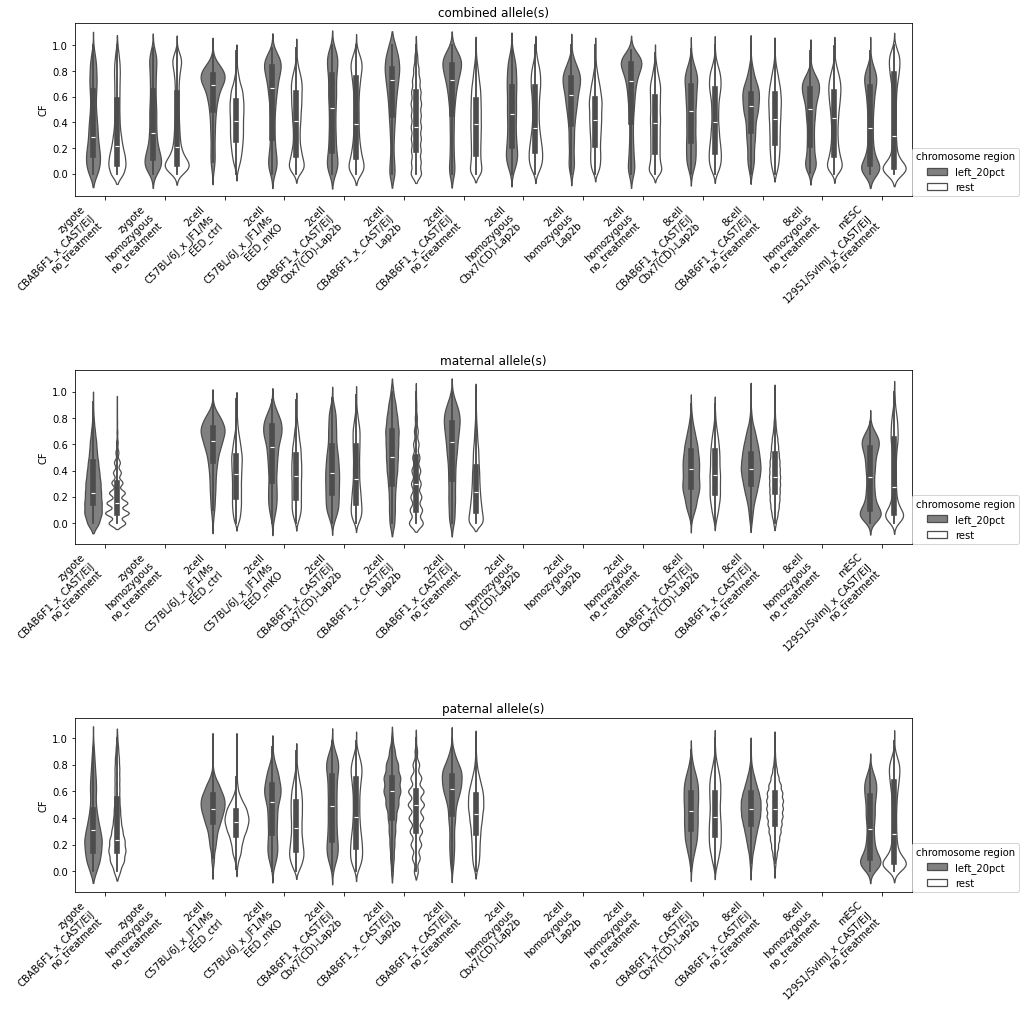

In [31]:
sample_order = to_plot['label'].unique()

fig, axes = plt.subplots(3, 1, figsize=(15,16))
plt.subplots_adjust(hspace=1)

clrs = {
    'left_%dpct' % PCT_LEFT_ARM: 'grey',
    'rest': 'white'
}

for irow, allele in enumerate(['combined', 'maternal', 'paternal']):

    ind = to_plot.allele==allele
    ax = axes[irow]
    ax.set_title('%s allele(s)' % allele)

    sns.violinplot(
        x=to_plot.loc[ind,'label'], 
        y=to_plot.loc[ind, 'CF'], 
        hue=to_plot.loc[ind, 'region'], 
        palette=clrs,
        order=sample_order,
        ax = ax
    )
    ax.legend(loc=(1,0), title='chromosome region')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')

outfn = FIGOUTDIR + 'CF_distribution_of_left_arm_vs_rest.left_%dpct.pdf' % PCT_LEFT_ARM
plt.savefig(outfn, bbox_inches='tight')

In [32]:
for (stage, genotype, treatment, allele), df in to_plot.groupby(['stage', 'genotype', 'treatment', 'allele']):
    
    A = df.loc[df.region == 'left_20pct', 'CF'].values
    B = df.loc[df.region == 'rest', 'CF'].values
    results = stats.ranksums(A, B, alternative='two-sided')
    
    stat_test_results['stage'].append(stage)
    stat_test_results['genotype'].append(genotype)
    stat_test_results['treatment'].append(treatment)
    stat_test_results['allele'].append(allele)
    stat_test_results['region_1'].append('left_20pct')
    stat_test_results['region_2'].append('rest')
    stat_test_results['N_1'].append(len(A))
    stat_test_results['N_2'].append(len(B))
    stat_test_results['mean_1'].append(np.mean(A))
    stat_test_results['mean_2'].append(np.mean(B))
    stat_test_results['median_1'].append(np.median(A))
    stat_test_results['median_2'].append(np.median(B))
    stat_test_results['std_1'].append(np.std(A))
    stat_test_results['std_2'].append(np.std(B))
    stat_test_results['wilcoxon_stat'].append(results[0])
    stat_test_results['wilcoxon_pval'].append(results[1])

In [33]:
stat_test_results = pd.DataFrame(stat_test_results).sort_values(by=['stage', 'genotype', 'treatment', 'allele'])

In [34]:
outfn = FIGOUTDIR + 'CF_distribution_of_20pct_left_arm_vs_rest.statistical_test_results.tsv'
stat_test_results.to_csv(outfn, sep='\t', header=True, index=False)